In [1]:
try:
  import wfdb
except:
  !pip install wfdb
  import wfdb

try:
  import numpy as np
except:
  !pip install numpy
  import numpy as np
    
try:
  import pandas as pd
except:
  !pip install pandas
  import pandas as pd

try:
  import scipy
except:
  !pip install scipy
  import singal
    
try:
  import seaborn as sns
except:
  !pip seaborn scipy
  import seaborn as sns

try:
  import matplotlib.pyplot as plt
except:
  !pip install matplotlib
  import matplotlib.pyplot as plt

try:
    import tqdm
except:
    !pip install tqdm
    
%config InlineBackend.figure_formats = ['svg']


from enum import IntEnum

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
sns.set_theme(style="whitegrid", font='Cambria')
# sns.set_style("whitegrid")
# plt.style.use('bmh')


In [2]:
signals, fields = wfdb.rdsamp('./raw/1001/491af4aa-941a-4a89-b74c-b38d91cfc5e9')

# This is a hack, don't do it
Channels = IntEnum('ChannelIndexEnum', fields["sig_name"], start=0)

fs = fields['fs']

# Signlas

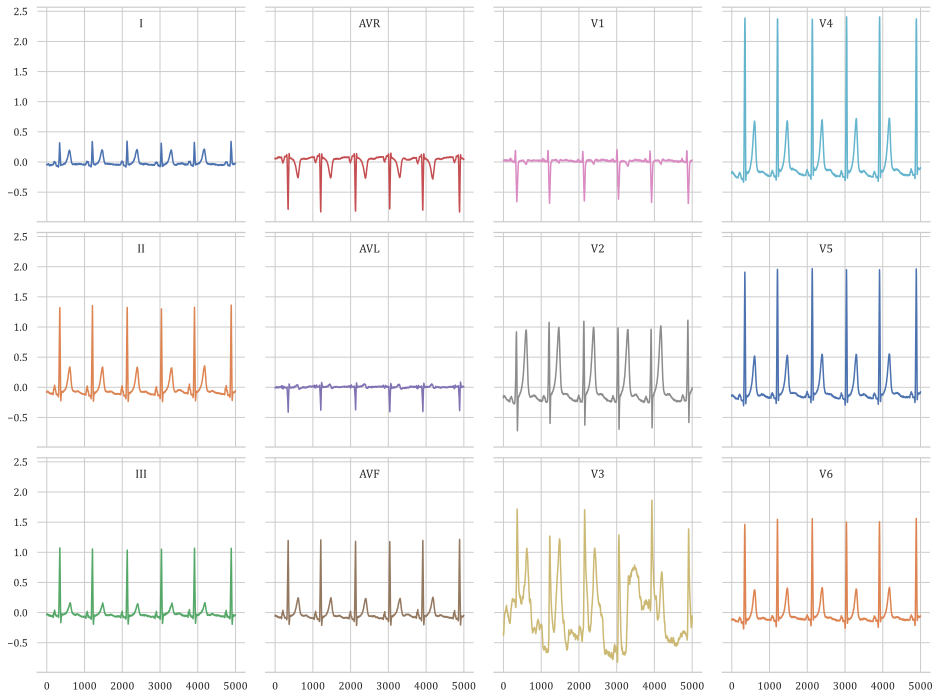

In [3]:
colors = plt.rcParams["axes.prop_cycle"]()

cols = 4
rows = signals.shape[1] // cols

fig, ax = plt.subplots(rows, cols,  figsize=(16,12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.1)
for i in range(signals.shape[1]):
    ax[i%rows, i // rows].set_title(fields["sig_name"][i], size=12, y=1.0, pad=-20)
    ax[i%rows, i // rows].plot(signals[:,i][:5000], color=next(colors)["color"])
   
    ax[i%rows, i // rows].spines['left'].set_visible(False)
    ax[i%rows, i // rows].spines['right'].set_visible(False)



# Peaks detection

In [4]:
def signal_clean(signal: np.array, Fs: int):
  sos = scipy.signal.butter(N=2, Wn=[8, 20], btype="bandpass", fs=Fs, output="sos")
  return scipy.signal.sosfiltfilt(sos, signal)


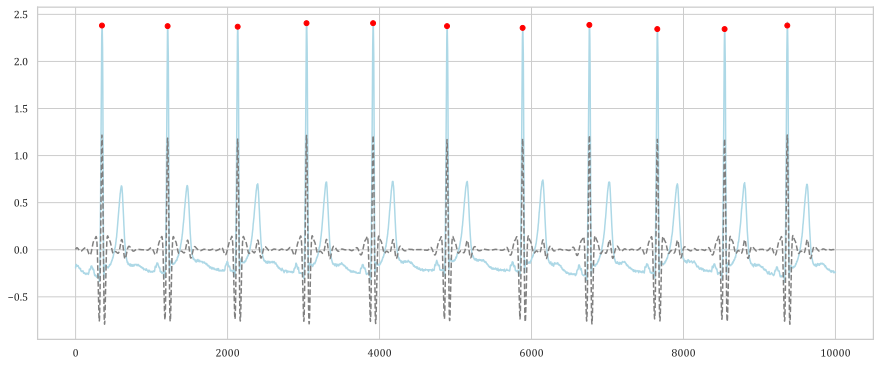

In [5]:
def rollavg(signal: np.array, n: int):

    mwa = scipy.ndimage.uniform_filter1d(
        signal, n, origin=(n - 1) // 2
    )

    head_size = min(n - 1, len(signal))
    mwa[:head_size] = np.cumsum(signal[:head_size]) / np.linspace(
        1, head_size, head_size
    )

    return mwa


def peak_detection(ecg: np.array, Fs: int):

    W1 = int(0.12 * Fs)
    W2 = int(0.60 * Fs)

    mwa_qrs  = rollavg(abs(ecg), W1)
    mwa_beat = rollavg(abs(ecg), W2)

    blocks = np.zeros(len(ecg), dtype='int')

    blocks = mwa_qrs > mwa_beat

    QRS = []

    qrs_duration_threshold = int(0.08 * Fs)
    rr_distance_threshold = int(0.3 * Fs)

    for i, (prev, cur) in enumerate(zip(blocks, blocks[1:])):
        if prev <  cur:      # fucked up version of "prev == 0 and cur == 1"
            start = i
        elif prev > cur:
            end = i-1

            if end - start > qrs_duration_threshold:
                detection = np.argmax(ecg[start : end + 1]) + start
                if len(QRS):
                    if detection - QRS[-1] > rr_distance_threshold:
                        QRS.append(detection)
                else:
                    QRS.append( detection)
    
    return np.array(QRS, dtype="int")

# clean = np.apply_along_axis(lambda x: signal_clean(x, 1000), axis=0, arr=signals)

sig = signals[:, Channels.V4]
filtered = signal_clean(sig, fs)
r_peaks = peak_detection(filtered, fs)

plt.figure(figsize=(15,6))
plt.plot(sig, color='lightblue')
plt.plot(filtered, '--', color='grey')
plt.plot(r_peaks, sig[r_peaks], '.', color='red', markersize=10)

        

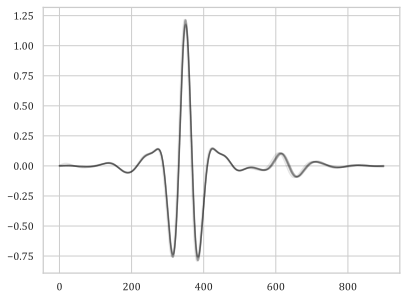

In [6]:
def ecg_segment(ecg_signal: np.array, r_peaks: np.array, fs: int, start = -0.35, stop = 0.55):
    duration = (stop - start) * fs
    segments = []
    start_offset = int(start * fs)
    end_offset = int(stop * fs)
    for peak in r_peaks:
        segments.append([ max(0, peak + start_offset), min(peak + end_offset, len(ecg_signal))])

    return np.array(segments, dtype='uint')


segments = ecg_segment(filtered,r_peaks, fs)

segmented_signal = [filtered[x:y] for x, y in segments]
for s in segmented_signal:
    plt.plot(s, color="black", alpha= 1.1 / len(segmented_signal))


(1000.0, 5000.0)

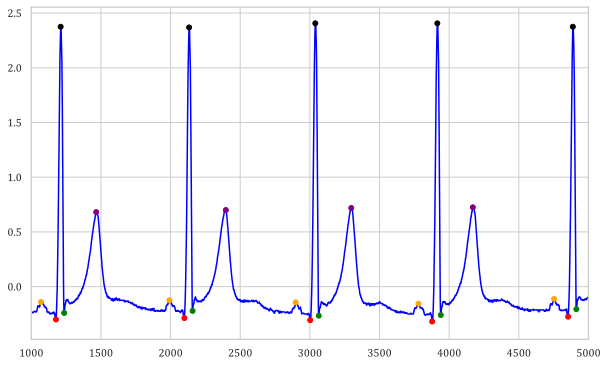

In [7]:

def extract_pqrst_features(ecg_signal: np.array, r_peaks: np.array):
    q_points = []
    s_points = []
    p_points = []
    t_points = []

    for r_peak in r_peaks:
        # QRS complex
        q_point = np.argmin(ecg_signal[max(0, r_peak - 80): r_peak]) + r_peak - 80
        s_point = np.argmin(ecg_signal[r_peak: min(len(ecg_signal), r_peak + 80)]) + r_peak
        q_points.append(q_point)
        s_points.append(s_point)

        # P wave
        p_point = np.argmax(ecg_signal[max(0, q_point - 200): q_point]) + q_point - 200
        p_points.append(p_point)

        # T wave
        t_point = np.argmax(ecg_signal[s_point: min(len(ecg_signal), s_point + 400)]) + s_point
        t_points.append(t_point)
    
    rr = np.diff(r_peaks)
    output = {
        "Q_peaks" : np.array(q_points, dtype='uint'),
        "S_peaks" : np.array(s_points, dtype='uint'),
        "P_peaks" : np.array(p_points, dtype='uint'),
        "T_peaks" : np.array(t_points, dtype='uint'),
        "RR"      : rr 
        
    }

    return output

pqrst_features = extract_pqrst_features(sig, r_peaks)


plt.figure(figsize=(10,6))
plt.plot(sig, color='blue')
plt.plot(r_peaks, sig[r_peaks], '.', color='black', markersize=10)
plt.plot(pqrst_features["Q_peaks"], sig[pqrst_features["Q_peaks"]], '.', color='red', markersize=10)
plt.plot(pqrst_features["S_peaks"], sig[pqrst_features["S_peaks"]], '.', color='green', markersize=10)
plt.plot(pqrst_features["P_peaks"], sig[pqrst_features["P_peaks"]], '.', color='orange', markersize=10)
plt.plot(pqrst_features["T_peaks"], sig[pqrst_features["T_peaks"]], '.', color='purple', markersize=10)
plt.xlim(1000,5000)


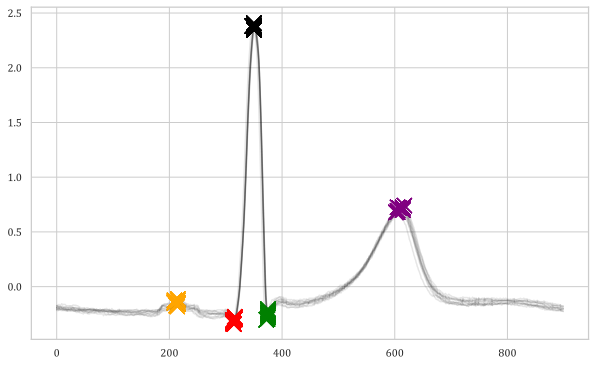

In [8]:
segmented_signal = [filtered[x:y] for x, y in segments]

plt.figure(figsize=(10, 6))
for x, y in segments:
    s = sig[x:y]
    plt.plot(s, color="black", alpha= 1.1 / len(segmented_signal))
    plt.plot(r_peaks  - segments[:,0], sig[r_peaks], 'x', color='black', markersize=15)
    plt.plot(pqrst_features["Q_peaks"] - segments[:,0], sig[pqrst_features["Q_peaks"]], 'x', color='red', markersize=15)
    plt.plot(pqrst_features["S_peaks"] - segments[:,0], sig[pqrst_features["S_peaks"]], 'x', color='green', markersize=15)
    plt.plot(pqrst_features["P_peaks"] - segments[:,0], sig[pqrst_features["P_peaks"]], 'x', color='orange', markersize=15)
    plt.plot(pqrst_features["T_peaks"] - segments[:,0], sig[pqrst_features["T_peaks"]], 'x', color='purple', markersize=15)
    

# Process signals

In [9]:

pd.set_option('display.max_columns', None)

df_in = pd.read_csv("./SCR-002.Clinical.Data.csv")


In [10]:
from tqdm.notebook import tqdm_notebook
bar = tqdm.notebook.tqdm(total=len(df_in) // 3)


def aggfunc(m):
    
    d = {
    'QTavg': 0,
    # 'RR': 0,
    'QTc': 0,
    }
    
    qt_tpt_list = []
    qtc_tpt_list = []
    
    for _, record in m.iterrows():
        record_name = record['EGREFID']  
        subject = record['RANDID']
        # print(f'\t\t\t./raw/{subject}/{record_name}')
        signals, fields = wfdb.rdsamp(f'./raw/{subject}/{record_name}')
        fs = fields["fs"]
        ecg = signals[:, Channels.V5]

        filtered_ecg = signal_clean(ecg, fs)
        r_peaks = peak_detection(filtered_ecg, fs)

        pqrst_features = extract_pqrst_features(ecg, r_peaks)
        t_peaks = pqrst_features["T_peaks"]
        q_peaks = pqrst_features["Q_peaks"]
        rr = pqrst_features["RR"]
        

        RR_std = np.std(rr)
        RR_mean = np.mean(rr)
        rr_filter = (rr > (RR_mean - RR_std) * 0.9) | (rr > (RR_mean + RR_std) * 1.1)

        RR_avg = np.average(rr[rr_filter])
        

        qt_avg = np.average(t_peaks- q_peaks) / fs

        RR_avg  /= fs

        qt_avg = np.average(t_peaks - q_peaks) / fs
        
        qtc_avg = qt_avg / np.sqrt(RR_avg)

        qt_tpt_list.append(qt_avg)
        qtc_tpt_list.append(qtc_avg)


    d['QTavg'] = np.average(qt_tpt_list)
    d['RR'] = RR_avg
    d['QTc'] = np.average(qtc_tpt_list)
    
    bar.update(1)

    return pd.Series(d)


df = df_in.groupby(['TPT', 'EXTRT', 'RANDID'], group_keys=True).apply(aggfunc)
df.index.rename({'EXTRT': 'Treatment'}, inplace=True)
df.reset_index(inplace=True)

  0%|          | 0/1744 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Heart rate–corrected global QT (QTc)')

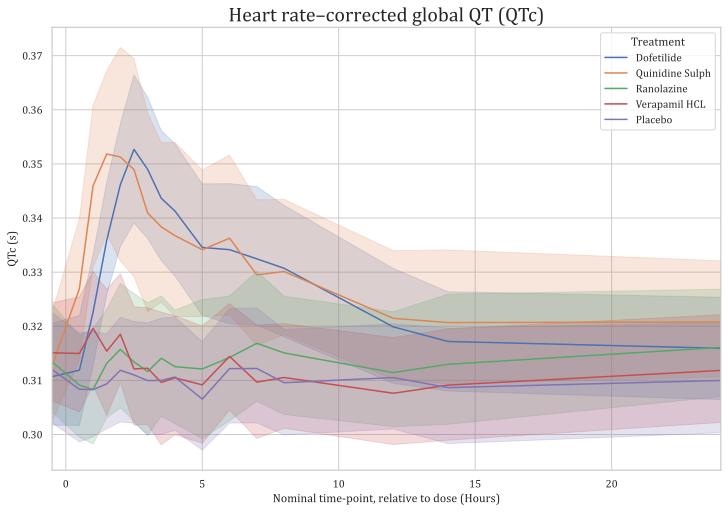

In [11]:
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.xlabel('Nominal time-point, relative to dose (Hours)')
plt.ylabel("QTc (s)")
plt.xlim(-0.5, 24)
sns.lineplot(df, x='TPT',  y='QTc', hue='Treatment', errorbar=("ci"), hue_order=["Dofetilide", "Quinidine Sulph", "Ranolazine", "Verapamil HCL", "Placebo"])
plt.title('Heart rate–corrected global QT (QTc)', size=20)


In [12]:
# save results in csv files

stats_df = df.groupby(['Treatment', 'TPT'], as_index=False).agg({'QTavg':['mean','std'], 'QTc': ['mean', 'std']})
stats_df.to_csv('stats.csv')

df.to_csv('patient_averages.csv')

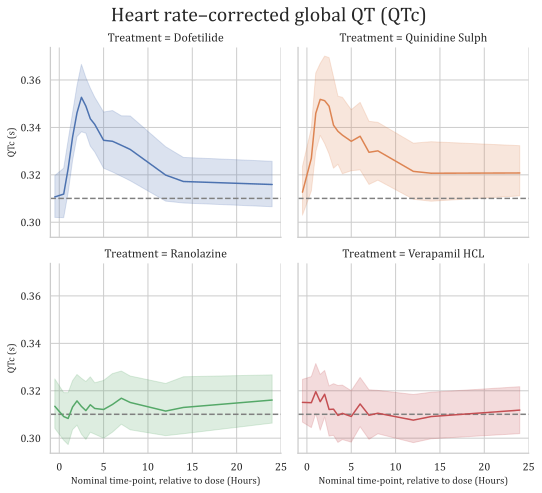

In [13]:
# Plot in seperate charts
g = sns.FacetGrid(df[df["Treatment"] != "Placebo"], col="Treatment", col_wrap=2, hue="Treatment", height=3.5, aspect=1.1)
g.refline(y= stats_df[stats_df["Treatment"] == "Placebo"]["QTc"]["mean"].mean())
g.map( sns.lineplot, "TPT", "QTc", errorbar=("ci"))
g.fig.subplots_adjust(top=0.9)
g.set_axis_labels("Nominal time-point, relative to dose (Hours)", "QTc (s)", size=10)
g.fig.suptitle('Heart rate–corrected global QT (QTc)', size=20)
g.set(xlim=(-1,25))


In [134]:

ranolazine_diff = []

for g, group in df.groupby(['RANDID', 'TPT']):
    _id, tpt = g
    if tpt == 1.5:
        try:
            ranolazine_diff.append(group[group['Treatment'] == 'Quinidine Sulph']['QTc'].iloc[0] - group[group['Treatment'] == 'Placebo']['QTc'].iloc[0])
        except:
            pass
        
np.mean(ranolazine_diff) * 1000, np.std(ranolazine_diff) * 1000

(42.71378929084731, 24.177471350429776)